In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from src import create_fake_patients, whole_model_demographics_gradcam, graph_plot, plot_feature_value, ga

In [2]:

second_TGCNN_layer = True
demo = True


stride = 1
filter_size = 4
num_filters = 16
years_in_advance = '5'
hip_or_knee='hip'
max_timesteps=100
include_drugs = True
if include_drugs:
    max_event_codes = 518
else:
    max_event_codes = 512

# fake mapping dataframe for the ReadCodes and the corresponding descriptions
read_code_map_df = pd.read_csv('fake_read_code_descriptions.csv')

model = whole_model_demographics_gradcam.TGCNN_Model(num_filters=num_filters, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=filter_size, variable_gamma=True, 
                            exponential_scaling=True, dropout_rate=0.7, lstm_units=64,
                            fcl1_units=128, LSTM_ablation=False, stride=stride, activation_type='LeakyReLU', 
                            no_timestamp=False, second_TGCNN_layer=second_TGCNN_layer, num_labels=1)
model.load_weights('hip_1999_to_one_year_advance_model1_CNN_layer')

# Load in the filters from the model
with open('hip_1999_to_one_year_advance_model1_filter.npy', 'rb') as f:
    filters = np.load(f)


normalised gamma [[0.04218759]]
normalised gamma [[-0.04056034]]


### Get the violin plots to show maximum activation difference

In [3]:
num_patients = 10

pat_df = create_fake_patients.create_fake_patient_df(num_patients=num_patients, max_events=max_timesteps-1, max_nodes=max_event_codes)

replacement_true_lst, max_w_filt_lst, filt_nums = ga.get_max_act_per_feat(model, num_filters, num_patients, pat_df, max_event_codes, hip_or_knee)


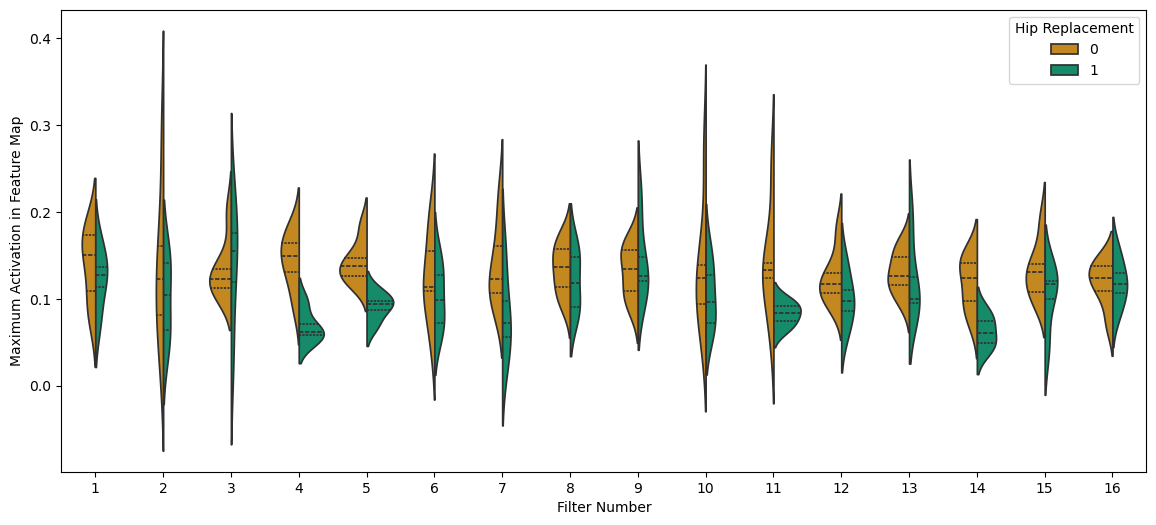

In [4]:
plot_feature_value.violin_plots(filt_nums, max_w_filt_lst, replacement_true_lst)

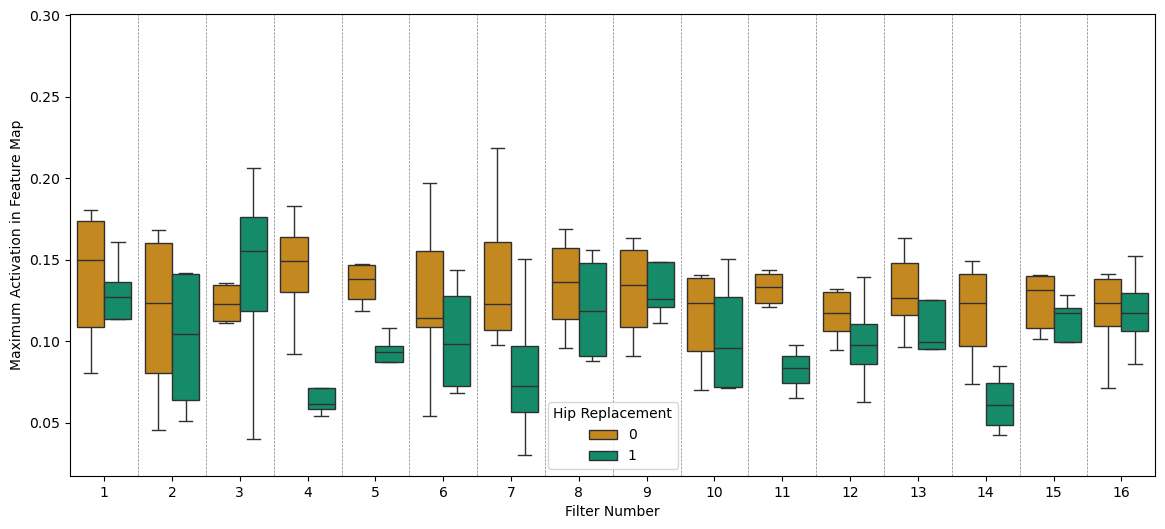

In [5]:
plot_feature_value.max_act_box_plots(filt_nums, max_w_filt_lst, replacement_true_lst)

### Calculate the strongest difference in activation between the patient and control participants

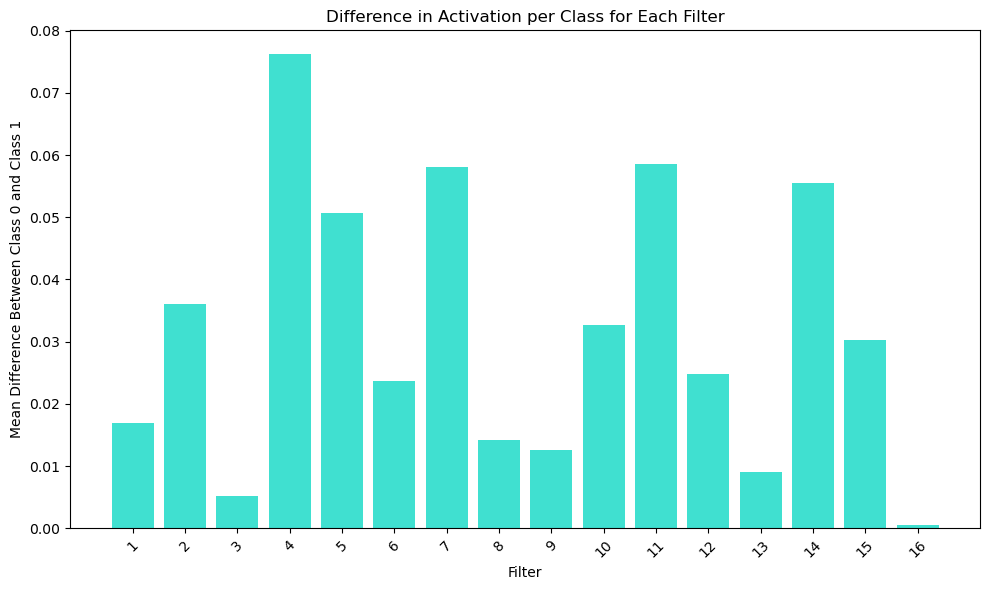

In [6]:
mean_activation_df = ga.act_diff(replacement_true_lst, max_w_filt_lst, filt_nums)

In [9]:
# Graph with edges from one filter

In [10]:
# Graph with edges from an average of all filters?
# Or remove feature maps with lower activations.